In [ ]:
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import StandardScaler
from datetime import timedelta
from hmmlearn.hmm import GaussianHMM
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_ta as ta
import warnings

warnings.filterwarnings('ignore')

In [5]:
#Using parquet because massive dataset
df = pd.read_parquet("/Users/connorshen/Documents/all_stock_data.parquet")
df["Date"] = pd.to_datetime(df["Date"])
df

,Date,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1962-01-02,ED,0.000000,0.265828,0.261788,0.261788,25600.0,0.0,0.0
1,1962-01-02,CVX,0.000000,0.046809,0.046069,0.046809,105840.0,0.0,0.0
2,1962-01-02,GD,0.000000,0.210033,0.203061,0.208290,2648000.0,0.0,0.0
3,1962-01-02,BP,0.000000,0.141439,0.139528,0.139528,77440.0,0.0,0.0
4,1962-01-02,MSI,0.000000,0.764923,0.745254,0.751810,65671.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
34646253,2024-11-04,NEOG,14.490000,14.580000,14.340000,14.345000,18972.0,0.0,0.0
34646254,2024-11-04,ENLV,1.400000,1.428900,1.330000,1.350000,28794.0,0.0,0.0
34646255,2024-11-04,FAMI,0.320000,0.320000,0.300100,0.300100,77650.0,0.0,0.0
34646256,2024-11-04,NNN,43.730000,43.439999,43.209999,43.244999,88675.0,0.0,0.0


In [6]:
df['Volume'].median()

53800.0

In [7]:
# Filter for recent rows only
cutoff = df["Date"].max() - timedelta(days=45)
df_recent = df[df["Date"] >= cutoff]

# Keep rows with valid Close and Volume only
df_recent = df_recent[(df_recent["Close"].notna()) & (df_recent["Volume"].notna())]

# Compute per-ticker stats (last close + avg volume)
summary = (
    df_recent.groupby("Ticker")
    .agg(LastPrice=('Close', 'last'), AvgVolume=('Volume', 'mean'))
)
# Filter by liquidity and price
filtered = summary.query("AvgVolume > 427_000 and LastPrice > 5")

# Get top 100 by average volume (faster than sort + head)
top_tickers = filtered.nlargest(100, "AvgVolume").index.tolist()

# Final filtered dataset
df_top100 = df[df["Ticker"].isin(top_tickers)]
df_top100

,Date,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits
17,1962-01-02,BA,0.190311,0.190311,0.187037,0.187037,352350.0,0.0,0.0
23,1962-01-02,KO,0.004007,0.004116,0.004007,0.004007,806400.0,0.0,0.0
27,1962-01-02,XOM,0.000000,0.101537,0.100789,0.100789,902400.0,0.0,0.0
41,1962-01-03,BA,0.189843,0.193584,0.189843,0.190778,710775.0,0.0,0.0
42,1962-01-03,XOM,0.000000,0.102286,0.100789,0.102286,1200000.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
34645932,2024-11-04,HOOD,23.750000,23.900000,23.540100,23.889999,1394526.0,0.0,0.0
34645942,2024-11-04,CSX,33.470001,33.805000,33.369999,33.770000,680096.0,0.0,0.0
34645985,2024-11-04,FCX,45.599998,46.160000,45.626900,46.110001,487766.0,0.0,0.0
34646132,2024-11-04,ITUB,6.060000,6.165000,6.125000,6.160000,987570.0,0.0,0.0


In [8]:
df_top100 = df_top100.reset_index(drop=True)
df_top100

,Date,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1962-01-02,BA,0.190311,0.190311,0.187037,0.187037,352350.0,0.0,0.0
1,1962-01-02,KO,0.004007,0.004116,0.004007,0.004007,806400.0,0.0,0.0
2,1962-01-02,XOM,0.000000,0.101537,0.100789,0.100789,902400.0,0.0,0.0
3,1962-01-03,BA,0.189843,0.193584,0.189843,0.190778,710775.0,0.0,0.0
4,1962-01-03,XOM,0.000000,0.102286,0.100789,0.102286,1200000.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
606027,2024-11-04,HOOD,23.750000,23.900000,23.540100,23.889999,1394526.0,0.0,0.0
606028,2024-11-04,CSX,33.470001,33.805000,33.369999,33.770000,680096.0,0.0,0.0
606029,2024-11-04,FCX,45.599998,46.160000,45.626900,46.110001,487766.0,0.0,0.0
606030,2024-11-04,ITUB,6.060000,6.165000,6.125000,6.160000,987570.0,0.0,0.0


In [9]:
def add_indicators(df):
    df = df.sort_values("Date") 
    df["rsi"] = ta.rsi(df["Close"], length=14)
    df["sma20"] = ta.sma(df["Close"], length=20)
    df["macd"] = ta.macd(df["Close"])["MACD_12_26_9"]
    df["atr"] = ta.atr(df["High"], df["Low"], df["Close"])
    df["daily_return"] = df["Close"].pct_change()
    bbands = ta.bbands(df["Close"], length=20)
    df["bb_percent"] = bbands["BBP_20_2.0"]
    df["price_to_sma"] = df["Close"] / df["sma20"]
    df["co_ratio"] = df["Close"] / df["Open"]
    df["volume_z"] = (df["Volume"] - df["Volume"].mean()) / df["Volume"].std()
    return df

df_features = df_top100.groupby("Ticker", group_keys=False).apply(add_indicators).dropna(subset=["rsi", "sma20", "macd", "atr"]).reset_index(drop=True)
df_features 

,Date,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits,rsi,sma20,macd,atr,daily_return,bb_percent,price_to_sma,co_ratio,volume_z
0,1962-02-06,XOM,0.000000,0.110768,0.109271,0.109521,1446400.0,0.00000,0.0,75.646111,0.103284,0.003284,0.001415,-0.013483,0.948958,1.060387,inf,-0.843747
1,1962-02-06,KO,0.003769,0.003769,0.003719,0.003719,691200.0,0.00000,0.0,45.517039,0.003728,-0.000058,0.000081,-0.013157,0.480739,0.997608,0.986843,-1.082624
2,1962-02-06,BA,0.205256,0.205728,0.200066,0.205256,801900.0,0.00000,0.0,65.384446,0.198258,0.007225,0.004999,0.000000,0.731260,1.035300,1.000000,-0.569059
3,1962-02-07,BA,0.205256,0.209031,0.203841,0.205256,844425.0,0.00000,0.0,65.384446,0.199216,0.006874,0.005015,0.000000,0.710682,1.030323,1.000000,-0.560594
4,1962-02-07,XOM,0.000000,0.110479,0.108714,0.110479,1126400.0,0.01875,0.0,77.559897,0.103843,0.003396,0.001444,0.008752,0.950844,1.063905,inf,-0.877327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603515,2024-11-04,HOOD,23.750000,23.900000,23.540100,23.889999,1394526.0,0.00000,0.0,42.221555,26.387000,0.453875,1.199428,-0.003338,0.023611,0.905370,1.005895,-0.994192
603516,2024-11-04,CSX,33.470001,33.805000,33.369999,33.770000,680096.0,0.00000,0.0,49.148475,33.970500,-0.192415,0.666130,0.011381,0.434500,0.994098,1.008963,-1.045723
603517,2024-11-04,FCX,45.599998,46.160000,45.626900,46.110001,487766.0,0.00000,0.0,44.584281,47.554500,-0.401666,1.241925,0.011406,0.225274,0.969624,1.011184,-0.999150
603518,2024-11-04,ITUB,6.060000,6.165000,6.125000,6.160000,987570.0,0.00000,0.0,45.167088,6.199500,-0.098237,0.130932,0.037037,0.395820,0.993628,1.016502,-1.297856


In [10]:
features_to_use = ["rsi", "sma20", "macd", "atr", "daily_return", "bb_percent", "price_to_sma", "co_ratio", "volume_z"]
df_features = df_top100.groupby("Ticker", group_keys=False).apply(add_indicators).dropna(subset=features_to_use).reset_index(drop=True)

# Remove inf/-inf and large magnitude outliers
df_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# cap extreme values
df_features = df_features[df_features[features_to_use].abs().lt(1e10).all(axis=1)]

# Drop remaining NaNs
df_features.dropna(subset=features_to_use, inplace=True)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_features[features_to_use])

# Add scaled versions to dataframe
scaled_cols = [f"{col}_scaled" for col in features_to_use]
df_features[scaled_cols] = features_scaled

df_features

,Date,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits,rsi,...,volume_z,rsi_scaled,sma20_scaled,macd_scaled,atr_scaled,daily_return_scaled,bb_percent_scaled,price_to_sma_scaled,co_ratio_scaled,volume_z_scaled
1,1962-02-06,KO,0.003769,0.003769,0.003719,0.003719,691200.0,0.0,0.0,45.517039,...,-1.082624,-0.523545,-0.039800,0.015255,-0.037813,-0.448115,-0.166291,-0.098431,-0.513906,-1.103729
2,1962-02-06,BA,0.205256,0.205728,0.200066,0.205256,801900.0,0.0,0.0,65.384446,...,-0.569059,1.097999,-0.039777,0.015267,-0.037804,-0.026793,0.586808,0.420899,-0.004523,-0.593125
3,1962-02-07,BA,0.205256,0.209031,0.203841,0.205256,844425.0,0.0,0.0,65.384446,...,-0.560594,1.097999,-0.039777,0.015266,-0.037804,-0.026793,0.524947,0.352324,-0.004523,-0.584708
5,1962-02-07,KO,0.003719,0.003739,0.003719,0.003739,192000.0,0.0,0.0,47.470303,...,-1.145577,-0.364123,-0.039800,0.015255,-0.037814,0.143994,0.025860,0.006188,0.201947,-1.166319
7,1962-02-08,BA,0.205728,0.209031,0.205728,0.205728,656100.0,0.0,0.0,66.102568,...,-0.598085,1.156611,-0.039776,0.015266,-0.037804,0.046791,0.512209,0.321818,-0.004523,-0.621983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603515,2024-11-04,HOOD,23.750000,23.900000,23.540100,23.889999,1394526.0,0.0,0.0,42.221555,...,-0.994192,-0.792517,-0.036599,0.016016,-0.035429,-0.133672,-1.540481,-1.369285,0.223694,-1.015806
603516,2024-11-04,CSX,33.470001,33.805000,33.369999,33.770000,680096.0,0.0,0.0,49.148475,...,-1.045723,-0.227153,-0.035679,0.014932,-0.036489,0.337659,-0.305294,-0.146788,0.342494,-1.067040
603517,2024-11-04,FCX,45.599998,46.160000,45.626900,46.110001,487766.0,0.0,0.0,44.584281,...,-0.999150,-0.599675,-0.034030,0.014581,-0.035345,0.338471,-0.934255,-0.483985,0.428482,-1.020736
603518,2024-11-04,ITUB,6.060000,6.165000,6.125000,6.160000,987570.0,0.0,0.0,45.167088,...,-1.297856,-0.552108,-0.039048,0.015090,-0.037553,1.159270,-0.421571,-0.153255,0.634347,-1.317720


Model is not converging.  Current: 5041602.073319402 is not greater than 5041602.07336301. Delta is -4.3608248233795166e-05
Model is not converging.  Current: 5041602.069756822 is not greater than 5041602.070663256. Delta is -0.0009064339101314545
Model is not converging.  Current: 3328791.3961077877 is not greater than 3328791.399913427. Delta is -0.00380563922226429
Model is not converging.  Current: 3328791.3961077877 is not greater than 3328791.399913427. Delta is -0.00380563922226429
Model is not converging.  Current: 6304347.429859164 is not greater than 6304347.435300499. Delta is -0.005441335029900074
Model is not converging.  Current: 6304347.429859164 is not greater than 6304347.435300499. Delta is -0.005441335029900074
Model is not converging.  Current: 4512738.640293088 is not greater than 4512738.641674424. Delta is -0.0013813357800245285
Model is not converging.  Current: 4512738.640293088 is not greater than 4512738.641674424. Delta is -0.0013813357800245285
Model is not

Best Config (Based on BIC):
n_components                  6
cov_type                   full
tol                      0.0001
BIC            -14726891.899113
Name: 31, dtype: object


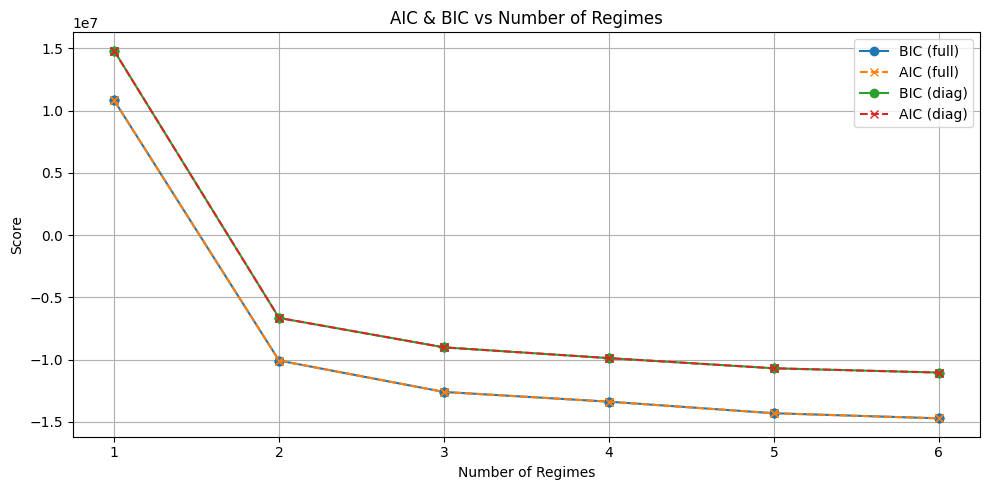

In [11]:
X = df_features[[f"{col}_scaled" for col in features_to_use]].dropna().values

# Define parameter search space
n_obs, n_features = X.shape
n_components_range = range(1, 7)  # Number of regimes to test
covariance_types = ['full', 'diag']  # Covariance matrix types
tolerances = [1e-2, 1e-4, 1e-6]  # Convergence tolerances

results = []

for n_components, cov_type, tol in product(n_components_range, covariance_types, tolerances):
    try:
        model = GaussianHMM(
            n_components=n_components,
            covariance_type=cov_type,
            tol=tol,
            n_iter=1000,
            random_state=42
        )
        model.fit(X)
        logL = model.score(X)

        # Estimate number of parameters
        k = n_components * (n_components - 1)  # transition probs
        k += n_components - 1                 # initial probs
        k += n_components * n_features * 2    # means and variances

        bic = -2 * logL + k * np.log(n_obs)
        aic = -2 * logL + 2 * k

        results.append({
            'n_components': n_components,
            'cov_type': cov_type,
            'tol': tol,
            'log_likelihood': logL,
            'AIC': aic,
            'BIC': bic
        })
    except Exception as e:
        results.append({
            'n_components': n_components,
            'cov_type': cov_type,
            'tol': tol,
            'log_likelihood': None,
            'AIC': np.inf,
            'BIC': np.inf,
            'error': str(e)
        })

# Convert to DataFrame and find best config
df_results = pd.DataFrame(results)
best_model = df_results.loc[df_results['BIC'].idxmin()]
print("Best Config (Based on BIC):")
print(best_model[["n_components", "cov_type", "tol", "BIC"]])

# Visualize BIC and AIC
plt.figure(figsize=(10, 5))
for cov in covariance_types:
    subset = df_results[df_results["cov_type"] == cov]
    plt.plot(subset["n_components"], subset["BIC"], label=f"BIC ({cov})", marker="o")
    plt.plot(subset["n_components"], subset["AIC"], label=f"AIC ({cov})", linestyle="--", marker="x")

plt.title("AIC & BIC vs Number of Regimes")
plt.xlabel("Number of Regimes")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
X

array([[-0.52354507, -0.03980026,  0.01525454, ..., -0.09843118,
        -0.51390616, -1.10372916],
       [ 1.09799886, -0.03977666,  0.01526675, ...,  0.42089944,
        -0.00452263, -0.59312497],
       [ 1.09799886, -0.03977654,  0.01526616, ...,  0.35232442,
        -0.00452263, -0.584708  ],
       ...,
       [-0.59967519, -0.03403022,  0.01458107, ..., -0.48398538,
         0.42848192, -1.02073566],
       [-0.55210753, -0.03904844,  0.0150899 , ..., -0.15325467,
         0.63434703, -1.31771951],
       [-1.05711689, -0.03466425,  0.01385864, ..., -0.7130409 ,
         0.16900348, -1.22041724]])

In [13]:
best_model

n_components                    6
cov_type                     full
tol                        0.0001
log_likelihood     7364394.824251
AIC              -14728503.648502
BIC              -14726891.899113
Name: 31, dtype: object

Model is not converging.  Current: 7364395.781726803 is not greater than 7364396.138688389. Delta is -0.3569615865126252


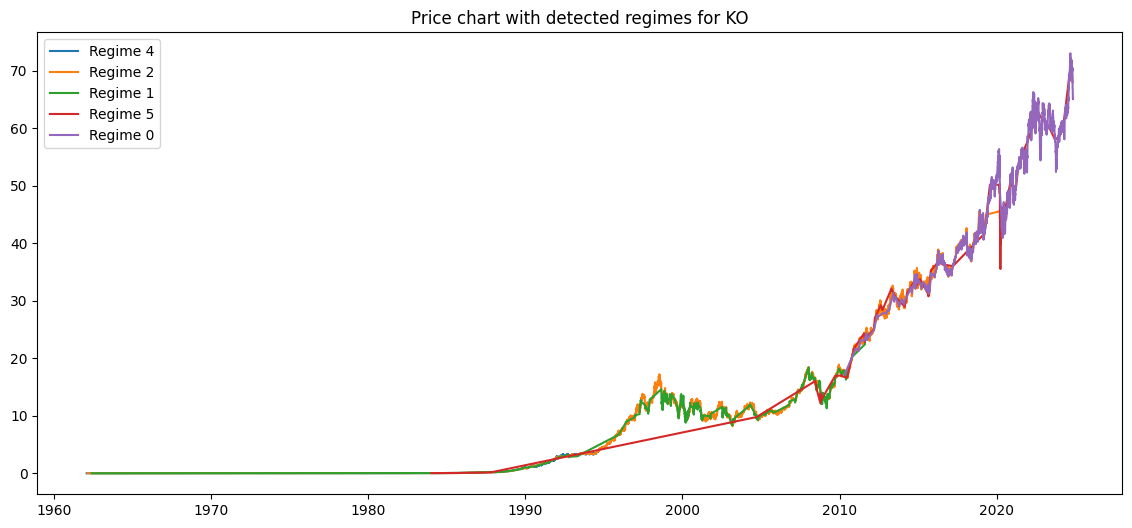

In [14]:
best_params = best_model

model = GaussianHMM(
    n_components=int(best_params['n_components']),
    covariance_type=best_params['cov_type'],
    tol=best_params['tol'],
    n_iter=1000,
    random_state=42
)
model.fit(X)

# Predict the hidden regime for each row
hidden_states = model.predict(X)

df_regime = df_features.dropna(subset=["rsi_scaled", "macd_scaled", "atr_scaled"]).copy()
df_regime["regime"] = hidden_states

sample_ticker = df_regime["Ticker"].iloc[0]  # use any ticker
sample_df = df_regime[df_regime["Ticker"] == sample_ticker]

plt.figure(figsize=(14, 6))
for state in sample_df["regime"].unique():
    subset = sample_df[sample_df["regime"] == state]
    plt.plot(subset["Date"], subset["Close"], label=f"Regime {state}")
plt.legend()
plt.title(f"Price chart with detected regimes for {sample_ticker}")
plt.show()

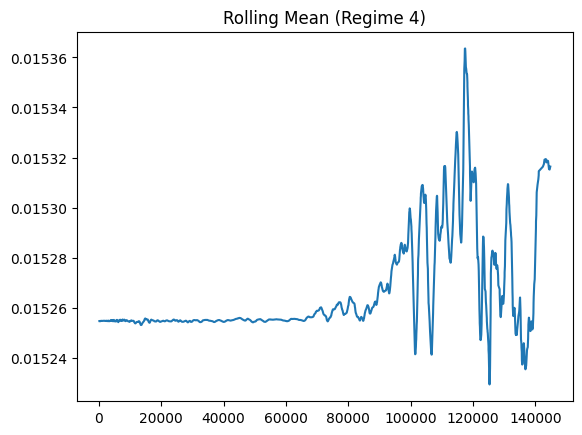

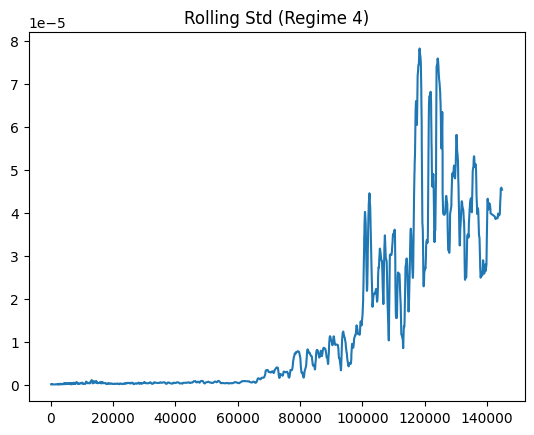

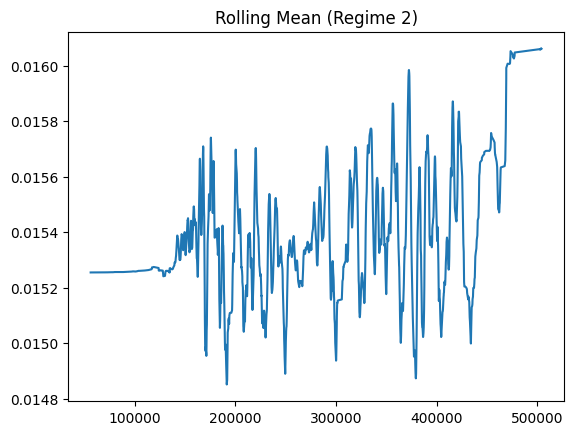

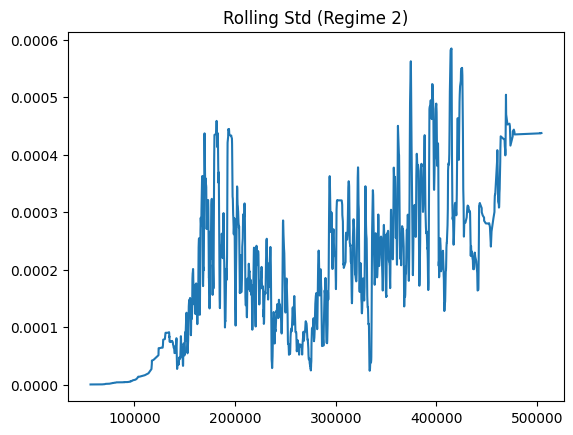

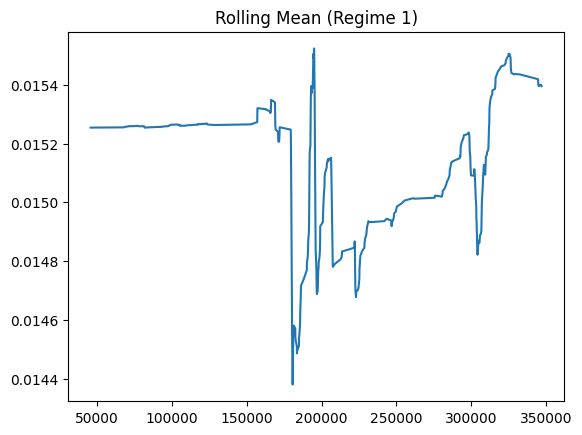

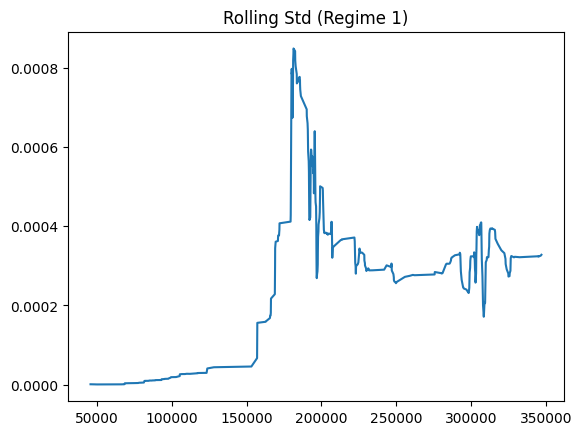

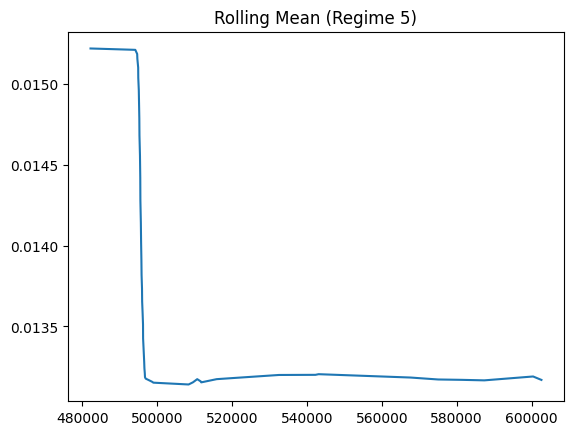

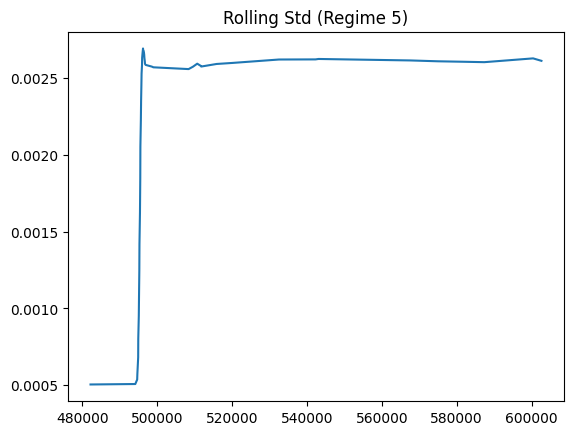

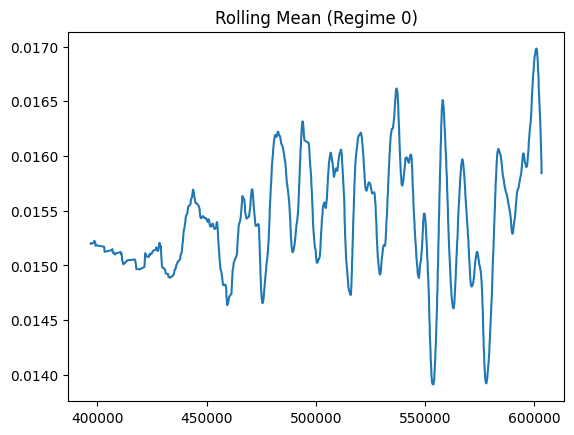

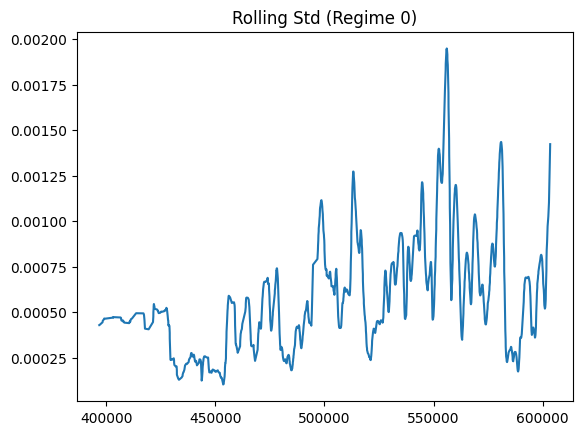

In [24]:
for regime in sample_df["regime"].unique():
    regime_data = sample_df[sample_df["regime"] == regime]["macd_scaled"]
    regime_data.rolling(50).mean().plot(title=f"Rolling Mean (Regime {regime})")
    plt.show()

    regime_data.rolling(50).std().plot(title=f"Rolling Std (Regime {regime})")
    plt.show()

In [25]:
transitions = pd.crosstab(
    sample_df["regime"].shift(), sample_df["regime"], normalize='index'
)
print("Empirical Transition Matrix:")
print(transitions)

Empirical Transition Matrix:
regime         0         1         2         4         5
regime                                                  
0.0     0.915245  0.000000  0.069767  0.000000  0.014987
1.0     0.003623  0.555556  0.257246  0.176329  0.007246
2.0     0.025503  0.039885  0.899137  0.031256  0.004219
4.0     0.000000  0.018917  0.020860  0.959705  0.000518
5.0     0.298969  0.144330  0.175258  0.010309  0.371134


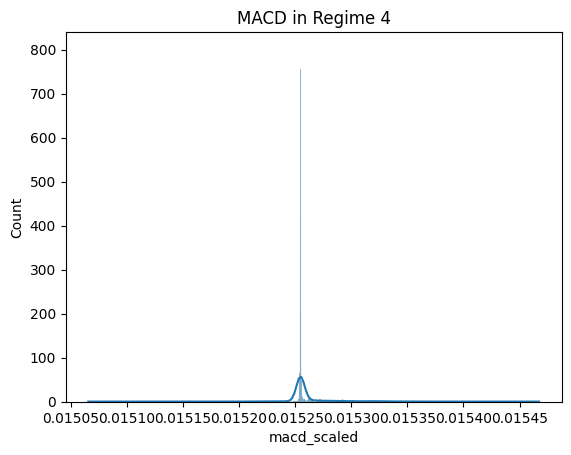

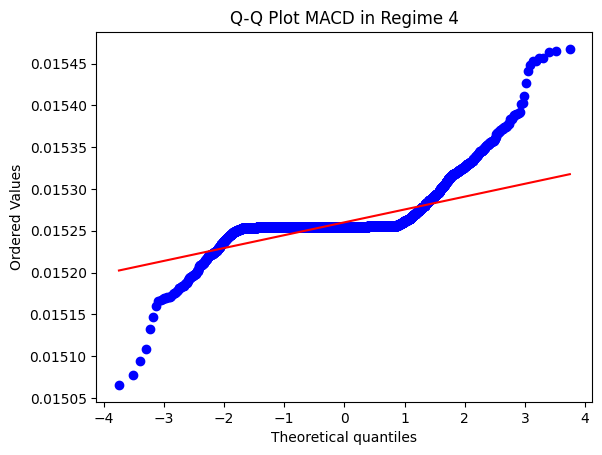

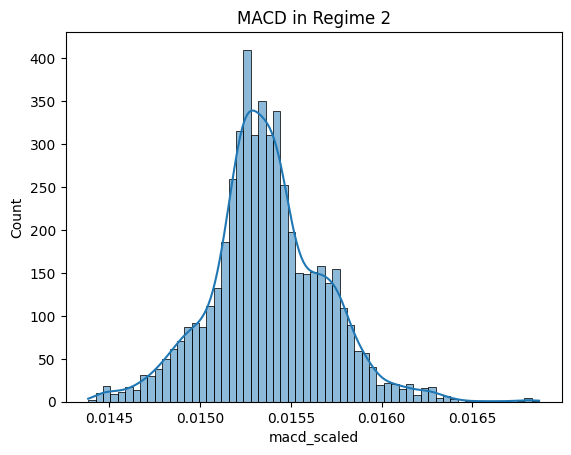

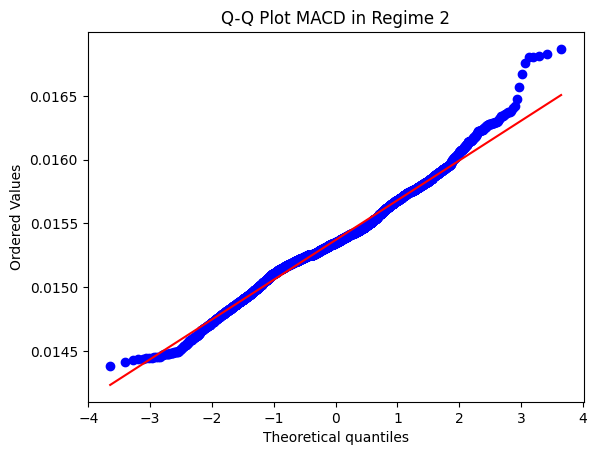

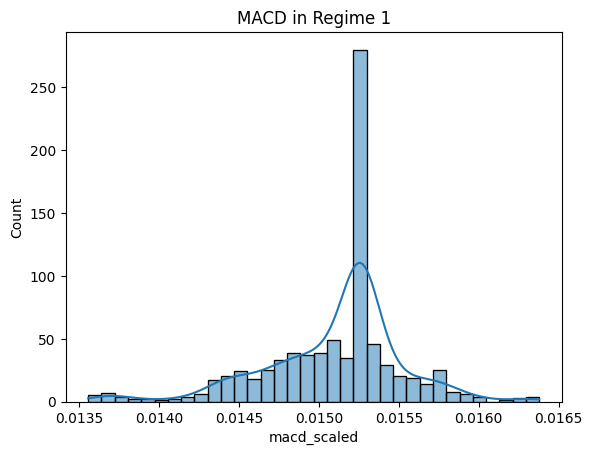

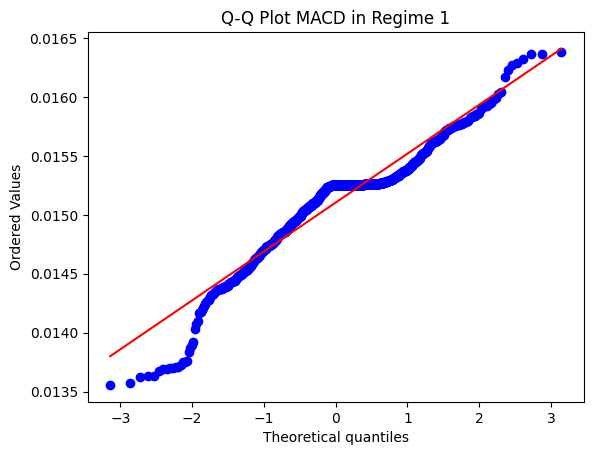

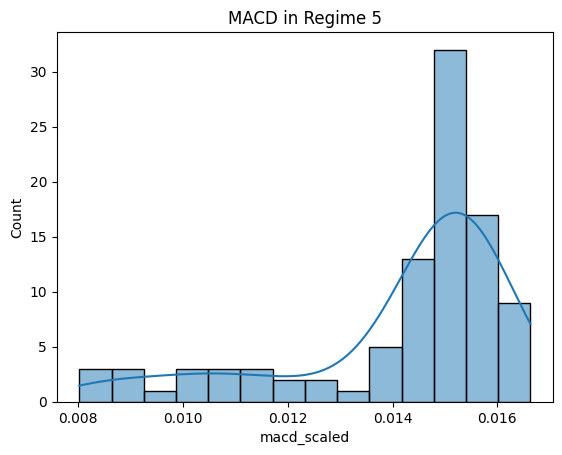

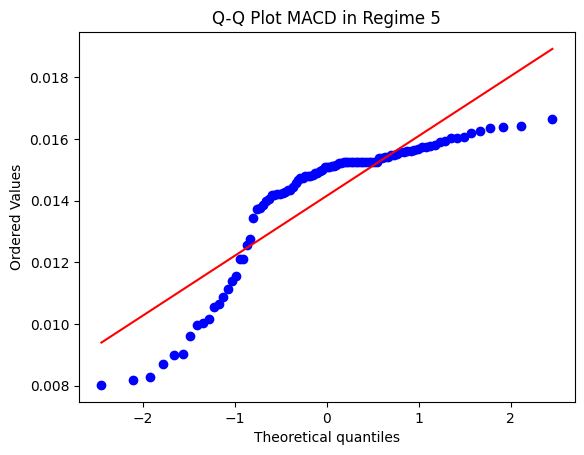

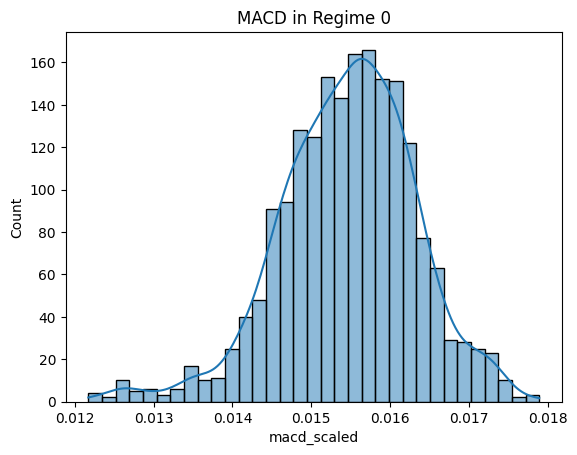

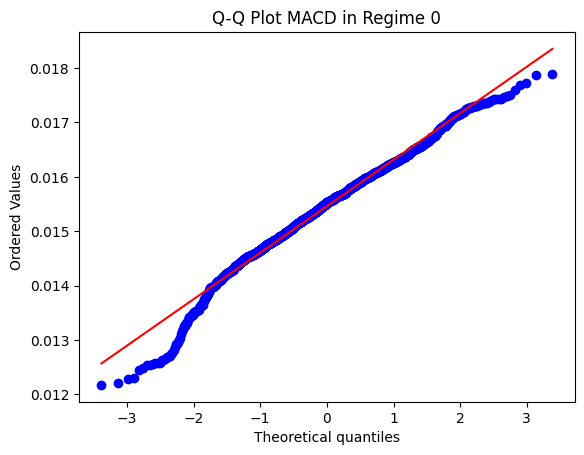

In [26]:
import scipy.stats as stats

for regime in sample_df["regime"].unique():
    sns.histplot(sample_df[sample_df["regime"] == regime]["macd_scaled"], kde=True)
    plt.title(f"MACD in Regime {regime}")
    plt.show()

    stats.probplot(sample_df[sample_df["regime"] == regime]["macd_scaled"], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot MACD in Regime {regime}")
    plt.show()

In [15]:
# 1. Calculate forward returns (e.g., 5-day return)
df_regime["future_return"] = df_regime.groupby("Ticker")["Close"].shift(-5) / df_regime["Close"] - 1

# 2. Get average future return per regime
regime_returns = df_regime.groupby("regime")["future_return"].mean().sort_values(ascending=False)

# 3. Map each regime to a signal
# Highest return → Buy, Lowest return → Sell, others → Hold
regime_signal_map = {}

# Assign Buy to top regime
regime_signal_map[regime_returns.index[0]] = "Buy"

# Assign Sell to worst regime
regime_signal_map[regime_returns.index[-1]] = "Sell"

# Assign Hold to all others
for regime in regime_returns.index[1:-1]:
    regime_signal_map[regime] = "Hold"

# 4. Map the signal back to the main DataFrame
df_regime["signal"] = df_regime["regime"].map(regime_signal_map)

In [22]:
# Prepare data
sample_ticker = df_regime["Ticker"].iloc[0]
sample_df = df_regime[df_regime["Ticker"] == sample_ticker].copy()

# Optional: get posterior probabilities (confidence in predicted regime)
# Assuming `model` is your fitted GaussianHMM
features_used = [col for col in sample_df.columns if "_scaled" in col]
X_sample = sample_df[features_used]
sample_df["posterior"] = model.predict_proba(X_sample).max(axis=1)

# Ensure 'signal' column is present in sample_df
# 1 = Buy, -1 = Sell, 0 = Hold
buy = sample_df[sample_df["signal"] == 1]
sell = sample_df[sample_df["signal"] == -1]
hold = sample_df[sample_df["signal"] == 0]

import plotly.graph_objects as go

# Prepare interactive plot
fig = go.Figure()

# Price line
fig.add_trace(go.Scatter(
    x=sample_df["Date"],
    y=sample_df["Close"],
    mode="lines",
    name="Close Price",
    line=dict(color="black")
))

# Buy / Sell / Hold markers
# Buy: green triangle-up
fig.add_trace(go.Scatter(
    x=buy["Date"],
    y=buy["Close"],
    mode="markers",
    name="Buy",
    marker=dict(color="green", symbol="triangle-up", size=10)
))
# Sell: red circle
fig.add_trace(go.Scatter(
    x=sell["Date"],
    y=sell["Close"],
    mode="markers",
    name="Sell",
    marker=dict(color="red", symbol="circle", size=9)
))
# Confidence line (posterior probabilities)
fig.add_trace(go.Scatter(
    x=sample_df["Date"],
    y=sample_df["posterior"],
    mode="lines",
    name="Confidence",
    line=dict(color="blue", dash="dot"),
    yaxis="y2"
))

# Define regime colors with more saturation
regime_colors = {
    0: "rgba(255, 0, 0, 0.4)",     # red
    1: "rgba(0, 255, 0, 0.4)",     # green
    2: "rgba(0, 0, 255, 0.4)",     # blue
    3: "rgba(255, 165, 0, 0.4)",   # orange
    4: "rgba(128, 0, 128, 0.4)",   # purple
    5: "rgba(0, 255, 255, 0.4)"    # cyan
}

# Track if a regime has already been added to the legend
regimes_added = set()

# Add shaded regime areas
for _, group in sample_df.groupby((sample_df["regime"] != sample_df["regime"].shift()).cumsum()):
    regime = group["regime"].iloc[0]
    color = regime_colors.get(regime, "rgba(200,200,200,0.4)")

    fig.add_trace(go.Scatter(
        x=[
            group["Date"].iloc[0], group["Date"].iloc[-1],
            group["Date"].iloc[-1], group["Date"].iloc[0]
        ],
        y=[
            sample_df["Close"].min(), sample_df["Close"].min(),
            sample_df["Close"].max(), sample_df["Close"].max()
        ],
        fill="toself",
        fillcolor=color,
        line=dict(width=0),
        mode="lines",
        name=f"Regime {regime}",
        legendgroup=f"Regime {regime}",
        showlegend=regime not in regimes_added,
        hoverinfo="skip",
        opacity=0.6
    ))

    regimes_added.add(regime)

# Layout with zoom + reset tools
fig.update_layout(
    title=f"Trading Signals and Regimes for {sample_ticker}",
    xaxis_title="Date",
    yaxis_title="Close Price",
    yaxis2=dict(
        title="Model Confidence",
        overlaying="y",
        side="right",
        range=[0, 1]
    ),
    legend=dict(orientation="h", y=1.1),
    height=600,
    hovermode="x unified"
)

fig.show()

Regime Performance Stats:
             mean       std  count  sharpe_ratio
regime                                         
0       0.000023  0.010152   1936      0.002292
1       0.004169  0.034625    828      0.120394
2       0.000700  0.010588   5215      0.066131
4       0.000572  0.013617   7717      0.042010
5      -0.000322  0.056688     97     -0.005679


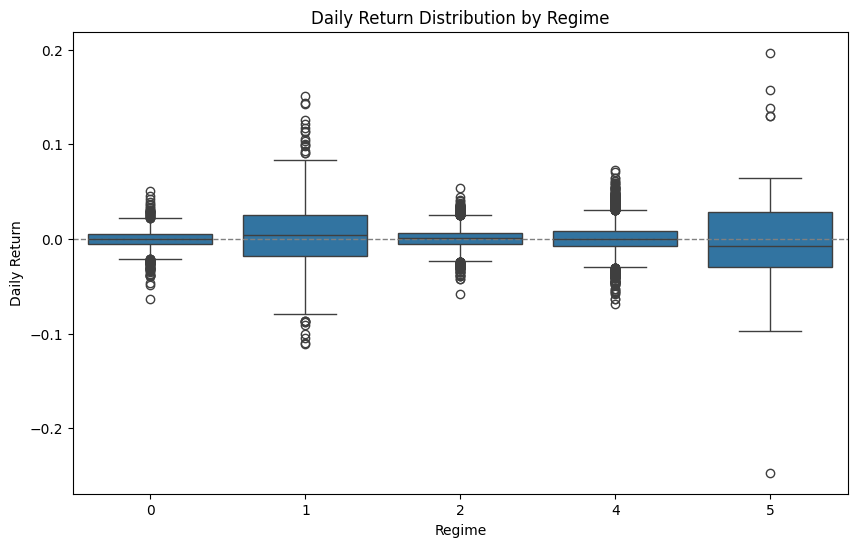

In [ ]:
# Ensure return column exists
sample_df["return"] = sample_df["Close"].pct_change()

# Group by regime and compute mean and volatility
regime_stats = sample_df.groupby("regime")["return"].agg(["mean", "std", "count"])
regime_stats["sharpe_ratio"] = regime_stats["mean"] / regime_stats["std"]
regime_stats = regime_stats.sort_index()

print("Regime Performance Stats:\n", regime_stats)

# Plot return distribution by regime
plt.figure(figsize=(10, 6))
sns.boxplot(x="regime", y="return", data=sample_df)
plt.title("Daily Return Distribution by Regime")
plt.axhline(0, linestyle="--", color="gray", linewidth=1)
plt.xlabel("Regime")
plt.ylabel("Daily Return")
plt.show()

"""
regime_to_signal = {
    0: "Hold",
    1: "Buy",
    2: "Hold",
    4: "Hold",
    5: "Sell"
}
"""

In [38]:
import yfinance as yf
import joblib
from datetime import datetime

joblib.dump(model, "best_hmm_model.pkl")
joblib.dump(scaler, "feature_scaler.pkl")

# Load model and scaler
model = joblib.load("best_hmm_model.pkl")
scaler = joblib.load("feature_scaler.pkl")

# Define feature engineering function
def compute_indicators(df):
    df["rsi"] = ta.rsi(df["close"], length=14)
    df["sma20"] = ta.sma(df["close"], length=20)
    
    macd = ta.macd(df["close"], fast=12, slow=26, signal=9)
    df["macd"] = macd["MACD_12_26_9"]
    
    df["atr"] = ta.atr(df["high"], df["low"], df["close"], length=14)
    df["daily_return"] = df["close"].pct_change()
    
    bb = ta.bbands(df["close"], length=20)
    df["bb_percent"] = (df["close"] - bb["BBL_20_2.0"]) / (bb["BBU_20_2.0"] - bb["BBL_20_2.0"])
    
    df["price_to_sma"] = df["close"] / df["sma20"]
    df["co_ratio"] = df["close"] / df["open"]
    
    df["volume_z"] = (df["volume"] - df["volume"].rolling(20).mean()) / df["volume"].rolling(20).std()
    
    return df.dropna()

# Map regimes to signals (adjust logic if needed)
regime_to_signal = {
    0: "Hold",
    1: "Buy",
    2: "Hold",
    3: "Hold",
    4: "Hold",
    5: "Sell"
}

# Daily signal function
def get_signal_for_today(ticker):
    # Download recent historical data
    start_date = (datetime.today() - timedelta(days=120)).strftime('%Y-%m-%d')
    df = yf.download(ticker, start=start_date)
    df

    if df.empty or len(df) < 60:
        return f"Not enough data for {ticker}"

    df = df.reset_index()
    df.columns = [col.lower() if isinstance(col, str) else str(col).lower() for col in df.columns]
    print("Downloaded columns:", df.columns)  # DEBUG LINE

    # Rename to match expected 'close'
    if "adj close" in df.columns:
        df.rename(columns={"adj close": "close"}, inplace=True)
    elif "close" in df.columns:
        pass  # Already fine
    else:
        raise ValueError("No 'close' or 'adj close' column found.")

    df = compute_indicators(df)

    # Select relevant features used during training
    feature_cols = ['rsi', 'macd', 'atr', 'bollinger_width', 'dollar_volume', 'gk_vol']
    X = scaler.transform(df[feature_cols])

    df["regime"] = model.predict(X)
    df["signal"] = df["regime"].map(regime_to_signal)

    # Return most recent signal
    latest = df.iloc[-1]
    return {
        "ticker": ticker,
        "date": latest["date"].date(),
        "regime": int(latest["regime"]),
        "signal": latest["signal"]
    }

# Example
print(get_signal_for_today("AAPL"))

[*********************100%***********************]  1 of 1 completed

Downloaded columns: Index(['('date', '')', '('close', 'aapl')', '('high', 'aapl')',
       '('low', 'aapl')', '('open', 'aapl')', '('volume', 'aapl')'],
      dtype='object')


ValueError: No 'close' or 'adj close' column found.

In [ ]:
"""
things to continue:

1. fix error above
2. implement ability to choose ticker
3. figure out if HMM model is actually valid. code already done below the model declaration.
3.5 build out STEP 7
4. make the trade signals bigger. cant tell from the graph


heres a catch up on current thought process:
- .venv(Python 3.11.5) is my environment and kernal
- STEP 1: loaded and clean historical data from parquet
- STEP 2: feature engineering. adding all the features: features_to_use = ["rsi", "sma20", "macd", "atr", "daily_return", "bb_percent", "price_to_sma", "co_ratio", "volume_z"]
- STEP 3: hyperparameter tune for best params
- STEP 4: build and validate the HMM model
- STEP 5: create comprehensive graph going over confidence level, regimes, and trade signals 
- STEP 6: figure out what each regime means. Regimes are hidden patterns, doesnt tell us what they are just that a pattern exists. All the regime 1 is buy, regime 5 is sell, other regimes are hold.
- STEP 7: backtest (NEED TO DO)
- STEP 8: download current data and figure out what regime we're currently in. 
"""